# Description

Data of 385 patients were collected in this database which can be divided into 4 different categories:
- Demographic information
- Patients other diseases
- Blood test results
- Vital Signs

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

# Read Dataset and Dataset Information

In [3]:
data = pd.read_excel('ICUfinal.xlsx')
icu_Data = data.iloc[:, 1:]
icu_Data.shape

(1925, 226)

- Show all columns

In [4]:
list(icu_Data.columns)

['PATIENT_VISIT_IDENTIFIER',
 'AGE_ABOVE65',
 'AGE_PERCENTIL',
 'GENDER',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ALBUMIN_MEDIAN',
 'ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'ALBUMIN_DIFF',
 'BE_ARTERIAL_MEDIAN',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_ARTERIAL_DIFF',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BE_VENOUS_DIFF',
 'BIC_ARTERIAL_MEDIAN',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_ARTERIAL_DIFF',
 'BIC_VENOUS_MEDIAN',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BIC_VENOUS_DIFF',
 'BILLIRUBIN_MEDIAN',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BILLIRUBIN_DIFF',
 'BLAST_MEDIAN',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'BLAST_DIFF',
 'CALCIUM_MEDIAN',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CALCIUM_DIFF',
 'CREATININ_MEDIAN',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'CREATININ_DIFF',
 'FFA_MEDIAN',
 'FFA_MEAN',
 'FFA_MI

# EDA Process 

- Cleaning Dada
- Visualisation
- Data information

## Cleaning Dada

- Analysis the non-numeric features
- Columns have same value
- Outliers
- Correlation between some columns
- Features Correlation by ICU
- Missing values

#### Columns have same value

In [5]:
columns_have_same_value = icu_Data.loc[:, icu_Data.nunique(axis=0) == 1].columns
icu_Data.drop(columns_have_same_value, axis=1)
icu_Data.shape

(1925, 226)

#### Analysis the non-numeric features.

In [6]:
obj_columns = icu_Data.select_dtypes(include=['object']).columns
obj_columns

Index(['AGE_PERCENTIL', 'WINDOW', 'tags'], dtype='object')

- Analysis tags column

In [7]:
icu_Data.tags.unique()

array(['Motor Neurone Disease, Smoker', nan, 'Motor Neurone Disease',
       'Lung cancer', 'asthma, Kidney disease, Motor Neurone Disease',
       'asthma, Motor Neurone Disease', 'Smoker',
       'asthma, Kidney disease', 'asthma',
       'heart disease, Kidney disease', 'heart disease',
       'asthma, Motor Neurone Disease, Smoker',
       'Lung cancer, asthma, Motor Neurone Disease, Smoker',
       'Lung cancer, Motor Neurone Disease',
       'Lung cancer, asthma, Motor Neurone Disease', 'asthma, Smoker',
       'Kidney disease', 'heart disease, Motor Neurone Disease',
       'Lung cancer, asthma', 'heart disease, asthma, Smoker',
       'heart disease, asthma, Motor Neurone Disease',
       'Lung cancer, heart disease', 'Lung cancer, asthma, Smoker',
       'heart disease, asthma', 'Lung cancer, Smoker',
       'Lung cancer, heart disease, asthma, Motor Neurone Disease',
       'Lung cancer, asthma, Kidney disease, Motor Neurone Disease, Smoker',
       'Lung cancer, heart diseas

In [8]:
dt = icu_Data.copy()
diseases = set()
for tag in dt["tags"].unique():
    try:
        items= tag.split(', ')
        diseases |= set(items)
    except:
        pass

for disease in diseases:
    dt[disease] = dt['tags'].str.contains(disease)
    dt[disease] = dt[disease].fillna(False).astype(int)

diseases

{'Kidney disease',
 'Lung cancer',
 'Motor Neurone Disease',
 'Smoker',
 'asthma',
 'heart disease'}

- Analysis AGE_PERCENTIL column

In [9]:
icu_Data.AGE_PERCENTIL.unique()

array(['60th', '90th', '10th', '40th', '70th', '20th', '50th', '80th',
       '30th', 'Above 90th'], dtype=object)

- Analysis WINDOW column

In [10]:
icu_Data.WINDOW.unique()

array(['0-2', '2-4', '4-6', '6-12', 'ABOVE_12'], dtype=object)

#### Outliers

In [11]:
def outliers(column):
    out = []
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    dif = q3 - q1
    lower = q1 - (1.5 * dif)
    upper = q3 + (1.5 * dif)
    for row in column:
        if row > upper or row < lower:
            out.append(row)
    return len(out)

outliers_num = []
for i in range(0, len(icu_Data.columns)):
    if icu_Data.dtypes[i] == 'float64':
        outliers_num.append(outliers(icu_Data[icu_Data.columns[i]]))
    else:
        outliers_num.append(0)
max(outliers_num)

409

As we se in maximum result of outliers;it's note very large number for due to the number of rows so we don't delete outliers numbers

#### correlation between some columns

Each medical meaturement has 4 parts mean, median, diff and diff_real.

check the correlation between every two columns!

In [12]:
def correlation_score(types: list,data):
    
    #correlation columns
    corr = data.corr().stack().reset_index().rename(columns = {'level_0': 'column1', 'level_1': 'column2', 0: 'correlation'}) 
    
    corr = corr.query('column1 != column2')
    chained_feature_names = ['-'.join(np.sort(x)) for x in corr[['column1', 'column2']].values]
    corr.loc[:,'duplicate'] = chained_feature_names
    corr = corr.drop_duplicates(subset = 'duplicate').drop(columns = 'duplicate')
    
    corr = corr[corr['column1'] != 'ICU']
    corr = corr[corr['column2'] != 'ICU']
    
    corr['correlation'] = abs(corr['correlation'])
    data_corr = corr.sort_values(by = 'correlation', ascending = False)
    data_corr['measure1'] = [k.split('_')[0] for k in data_corr['column1']]
    data_corr['measure2'] = [k.split('_')[0] for k in data_corr['column2']]
    data_corr['type1'] = [k.split('_')[-1] for k in data_corr['column1']]
    data_corr['type2'] = [k.split('_')[-1] for k in data_corr['column2']]

    type_corr = data_corr.query('measure1 == measure2')
    type_corr = type_corr.query('type1 != type2')
    type_corr = type_corr[type_corr['type1'].isin(types)]
    type_corr = type_corr[type_corr['type2'].isin(types)]

    relevant_cols = ['column1', 'column2', 'correlation']
    return type_corr[relevant_cols]

In [13]:
median_mean = correlation_score(["MEDIAN", "MEAN"], icu_Data)
median_mean

C:\Users\Ali\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ali\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,column1,column2,correlation
25945,TTPA_MEDIAN,TTPA_MEAN,1.000000
7897,FFA_MEDIAN,FFA_MEAN,1.000000
22185,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,1.000000
15417,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,1.000000
4889,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,1.000000
2633,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,1.000000
20681,PLATELETS_MEDIAN,PLATELETS_MEAN,1.000000
1129,ALBUMIN_MEDIAN,ALBUMIN_MEAN,1.000000
14665,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,1.000000
8649,GGT_MEDIAN,GGT_MEAN,1.000000


#### Features Correlation by ICU

In [14]:
corr_matrix = icu_Data.corr(method='pearson')
pd.set_option("display.max_rows", 2000, "display.max_columns", 20)
corr = abs(corr_matrix['ICU']).sort_values(ascending=False)
corr

ICU                                 1.000000
RESPIRATORY_RATE_MAX                0.588523
RESPIRATORY_RATE_DIFF               0.502663
RESPIRATORY_RATE_DIFF_REL           0.489765
LACTATE_MAX                         0.482143
LACTATE_MIN                         0.482143
LACTATE_MEAN                        0.482143
LACTATE_MEDIAN                      0.482143
RESPIRATORY_RATE_MEAN               0.428144
BLOODPRESSURE_SISTOLIC_DIFF         0.413082
BLOODPRESSURE_DIASTOLIC_MIN         0.405757
BLOODPRESSURE_SISTOLIC_DIFF_REL     0.403476
RESPIRATORY_RATE_MEDIAN             0.387823
BLOODPRESSURE_SISTOLIC_MAX          0.379264
BLOODPRESSURE_DIASTOLIC_DIFF_REL    0.376300
BLOODPRESSURE_DIASTOLIC_DIFF        0.361708
HEART_RATE_DIFF                     0.335091
HEART_RATE_DIFF_REL                 0.333011
TEMPERATURE_DIFF_REL                0.331295
TEMPERATURE_DIFF                    0.330577
BE_VENOUS_MAX                       0.315695
BE_VENOUS_MEAN                      0.315695
BE_VENOUS_

#### Misiing values

In [15]:
percent_missing = icu_Data.isnull().sum() * 100 / len(icu_Data)
percent_missing

PATIENT_VISIT_IDENTIFIER             0.000000
AGE_ABOVE65                          0.000000
AGE_PERCENTIL                        0.000000
GENDER                               0.000000
HTN                                  0.259740
IMMUNOCOMPROMISED                    0.259740
OTHER                                0.259740
ALBUMIN_MEDIAN                      57.350649
ALBUMIN_MEAN                        57.350649
ALBUMIN_MIN                         57.350649
ALBUMIN_MAX                         57.350649
ALBUMIN_DIFF                        57.350649
BE_ARTERIAL_MEDIAN                  57.350649
BE_ARTERIAL_MEAN                    57.350649
BE_ARTERIAL_MIN                     57.350649
BE_ARTERIAL_MAX                     57.350649
BE_ARTERIAL_DIFF                    57.350649
BE_VENOUS_MEDIAN                    57.350649
BE_VENOUS_MEAN                      57.350649
BE_VENOUS_MIN                       57.350649
BE_VENOUS_MAX                       57.350649
BE_VENOUS_DIFF                    

## Visualisation

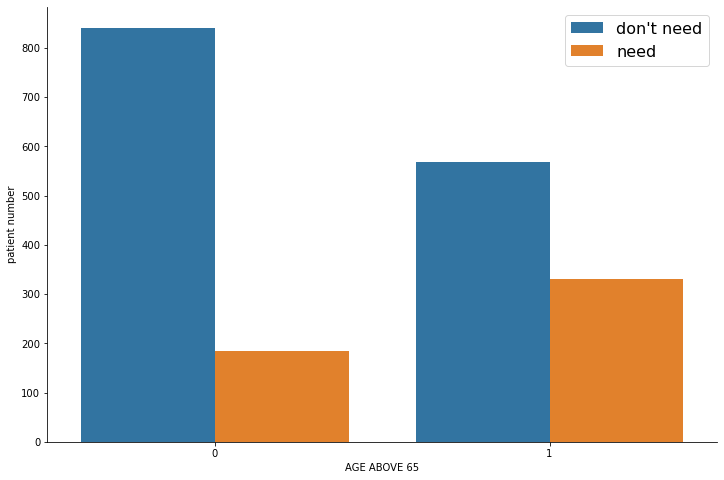

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x = 'AGE_ABOVE65',
              data = icu_Data,
              ax = ax,
              hue = "ICU")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["don't need", "need"], fontsize=16, title_fontsize=20)
sns.despine(right = True)
plt.ylabel("patient number")
plt.xlabel("AGE ABOVE 65")
plt.show()

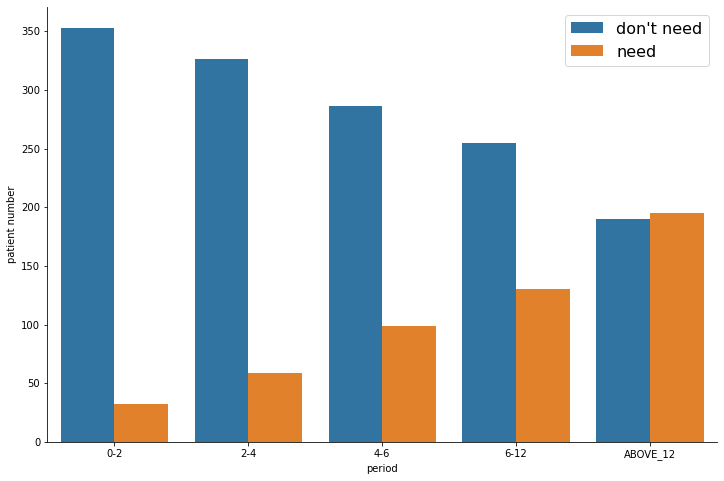

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x = "WINDOW",
              data = icu_Data,
              ax = ax,
              hue = "ICU")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["don't need", "need"], fontsize=16, title_fontsize=20)
sns.despine(right = True)
plt.ylabel("patient number")
plt.xlabel("period")
plt.show()

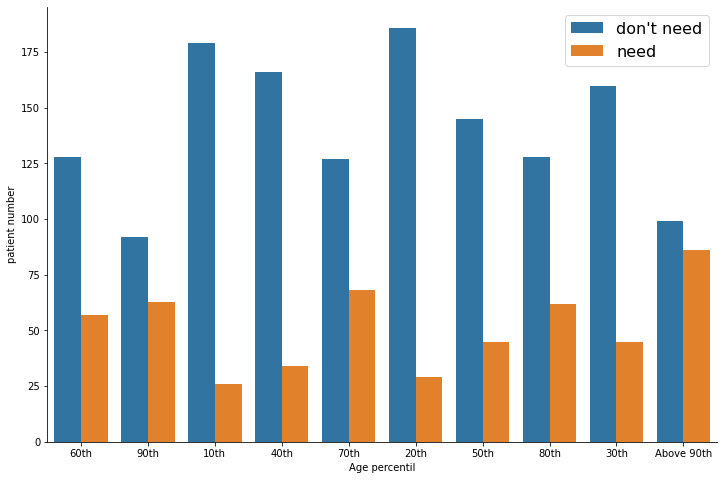

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x = "AGE_PERCENTIL",
              data = icu_Data,
              ax = ax,
              hue = "ICU")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["don't need", "need"], fontsize=16, title_fontsize=20)
sns.despine(right = True)
plt.ylabel("patient number")
plt.xlabel("Age percentil")
plt.show()

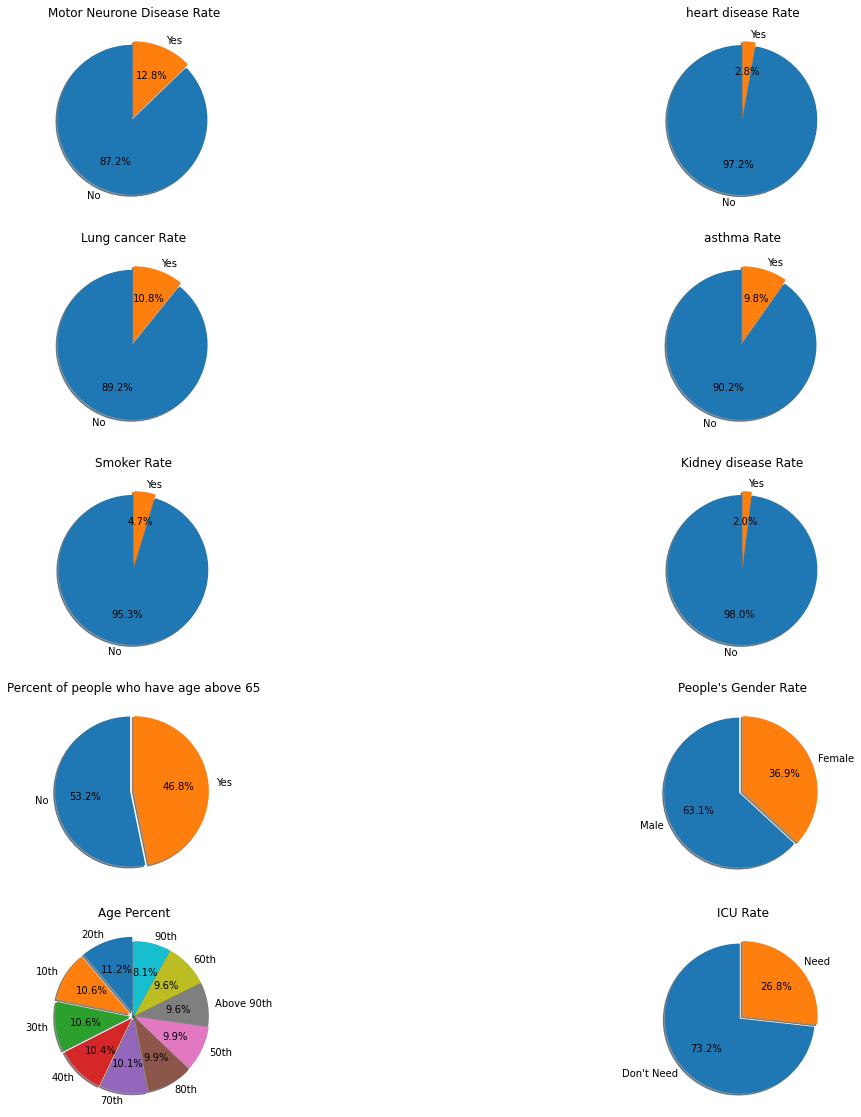

In [19]:
plt.figsize = (40, 20)
figure, axis = plt.subplots(5, 2, figsize=(20,20))

axis[0, 0].pie(list(dt['Motor Neurone Disease'].value_counts()), explode= [0.05, 0], labels=["No", "Yes"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[0, 0].title.set_text("Motor Neurone Disease Rate")
# -------------------------------------------------------------------------------------------------------------------------
axis[0, 1].pie(list(dt['heart disease'].value_counts()), explode= [0.05, 0], labels=["No", "Yes"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[0, 1].title.set_text("heart disease Rate")
# -------------------------------------------------------------------------------------------------------------------------
axis[1, 0].pie(list(dt['Lung cancer'].value_counts()), explode= [0.05, 0], labels=["No", "Yes"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[1, 0].title.set_text("Lung cancer Rate")
# -------------------------------------------------------------------------------------------------------------------------
axis[1, 1].pie(list(dt['asthma'].value_counts()), explode= [0.05, 0], labels=["No", "Yes"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[1, 1].title.set_text("asthma Rate")
# -------------------------------------------------------------------------------------------------------------------------
axis[2, 0].pie(list(dt['Smoker'].value_counts()), explode= [0.05, 0], labels=["No", "Yes"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[2, 0].title.set_text("Smoker Rate")
# -------------------------------------------------------------------------------------------------------------------------
axis[2, 1].pie(list(dt['Kidney disease'].value_counts()), explode= [0.05, 0], labels=["No", "Yes"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[2, 1].title.set_text("Kidney disease Rate")
# -------------------------------------------------------------------------------------------------------------------------
axis[3, 0].pie(list(dt['AGE_ABOVE65'].value_counts()), explode= [0.05, 0], labels=["No", "Yes"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[3, 0].title.set_text("Percent of people who have age above 65")
# -------------------------------------------------------------------------------------------------------------------------
axis[3, 1].pie(list(dt['GENDER'].value_counts()), explode= [0.05, 0], labels=["Male", "Female"], autopct='%1.1f%%', 
        shadow=True, startangle=90)
axis[3, 1].title.set_text("People's Gender Rate")
# -------------------------------------------------------------------------------------------------------------------------
axis[4, 0].pie(list(dt['AGE_PERCENTIL'].value_counts()), explode= [0.06, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0, 0, 0], 
               labels=["20th", "10th", "30th", "40th", "70th", "80th", "50th", "Above 90th", "60th", "90th"], 
               autopct='%1.1f%%', shadow=True, startangle=90)
axis[4, 0].title.set_text("Age Percent")
# -------------------------------------------------------------------------------------------------------------------------
axis[4, 1].pie(list(dt['ICU'].value_counts()), explode= [0.05, 0], labels=["Don't Need", "Need"], autopct='%1.1f%%', 
               shadow=True, startangle=90)
axis[4, 1].title.set_text("ICU Rate")

plt.show()

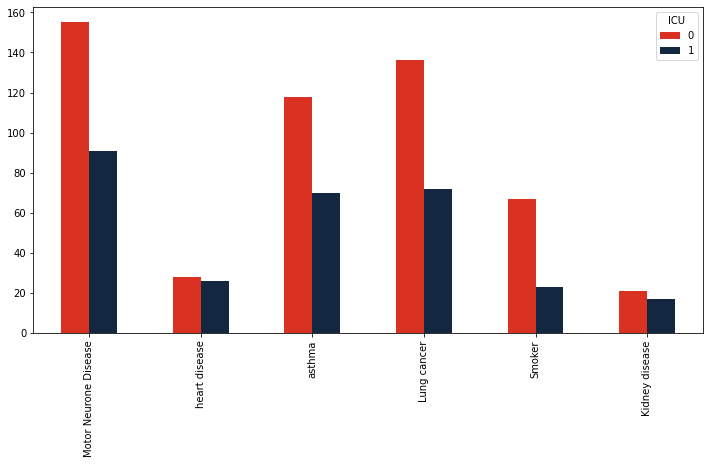

In [20]:
dt = dt.groupby('ICU').sum()
dt[diseases].T.plot(kind="bar", color=['#D93223', '#142740'], figsize=(12,6))
plt.show()

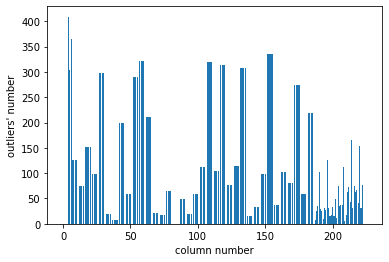

In [21]:
plt.bar(range(len(outliers_num)),outliers_num)
plt.xlabel("column number")
plt.ylabel("outliers' number")
plt.show()

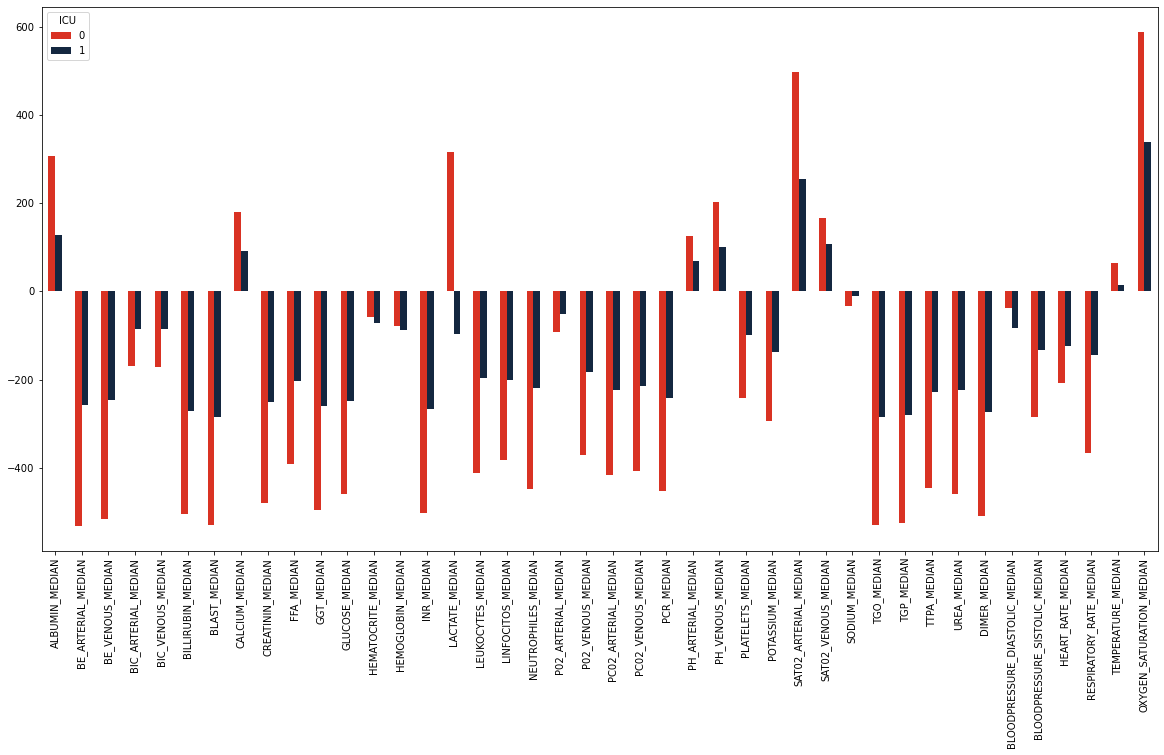

In [22]:
median = {}
for i in list(icu_Data.columns):
    if 'MEDIAN' in i:
        median[i] = i
median_df = dt[median]  
median_df.T.plot(kind="bar", color=['#D93223', '#142740'], figsize=(20,10))
plt.show()

In [23]:
df = icu_Data.copy()
df['RESPIRATORY'] = (df[['RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_DIFF', 'RESPIRATORY_RATE_DIFF_REL', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MEDIAN']]).mean(axis=1)
df['BLOODPRESSURE_SISTOLIC'] = (df[['BLOODPRESSURE_SISTOLIC_DIFF', 'BLOODPRESSURE_SISTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_DIFF_REL']]).mean(axis=1)
df['BLOODPRESSURE_DIASTOLIC'] = (df[['BLOODPRESSURE_DIASTOLIC_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN']]).mean(axis=1)
df['LACTATE'] = (df[['LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN', 'LACTATE_MAX']]).mean(axis=1)
df['BE_VENOUS'] = (df[['BE_VENOUS_MAX', 'BE_VENOUS_MEAN', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MIN']]).mean(axis=1)
df['BE_ARTERIAL'] = (df[['BE_ARTERIAL_MAX', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MIN']]).mean(axis=1)
df['HEART_RATE'] = (df[['HEART_RATE_DIFF', 'HEART_RATE_DIFF_REL', 'HEART_RATE_MAX']]).mean(axis=1)
df['LEUKOCYTES'] = (df[['LEUKOCYTES_MAX', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MIN']]).mean(axis=1)
df['TEMPERATURE'] = (df[['TEMPERATURE_DIFF', 'TEMPERATURE_DIFF_REL', 'TEMPERATURE_MIN']]).mean(axis=1)
df['ALBUMIN'] = (df[['ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX']]).mean(axis=1)
df['OXYGEN_SATURATION'] = (df[['OXYGEN_SATURATION_MIN', 'OXYGEN_SATURATION_DIFF', 'OXYGEN_SATURATION_DIFF_REL']]).mean(axis=1)
df['HEMOGLOBIN'] = (df[['HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN', 'HEMOGLOBIN_MAX']]).mean(axis=1)
df['HEMATOCRITE'] = (df[['HEMATOCRITE_MIN', 'HEMATOCRITE_MEAN', 'HEMATOCRITE_MAX', 'HEMATOCRITE_MEDIAN']]).mean(axis=1)
df['NEUTROPHILES'] = (df[['NEUTROPHILES_MIN', 'NEUTROPHILES_MAX', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MEDIAN']]).mean(axis=1)
df['UREA'] = (df[['HEMATOCRITE_MIN', 'HEMATOCRITE_MEAN', 'HEMATOCRITE_MAX', 'HEMATOCRITE_MEDIAN']]).mean(axis=1)

df = df[['ALBUMIN', 'OXYGEN_SATURATION', 'HEMOGLOBIN', 'NEUTROPHILES','AGE_ABOVE65', 'ICU', 'AGE_PERCENTIL', 'RESPIRATORY', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'TEMPERATURE', 'BE_VENOUS', 'BE_ARTERIAL', 'LEUKOCYTES', 'UREA', 'HEMATOCRITE', 'BLOODPRESSURE_DIASTOLIC', 'LACTATE', 'WINDOW']]

<AxesSubplot:>

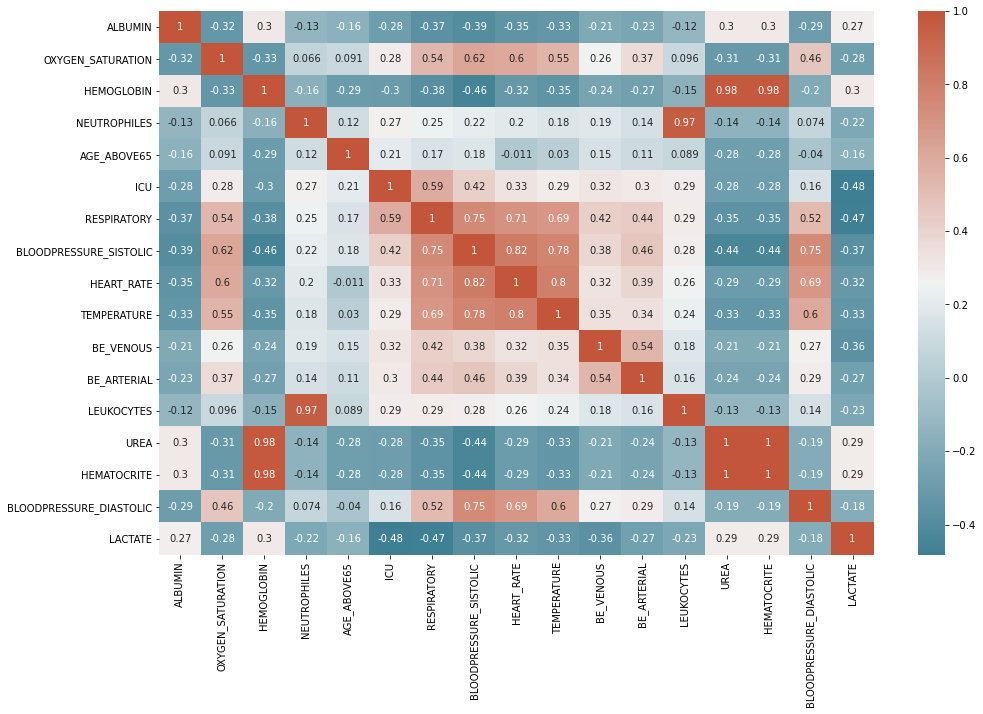

In [24]:
corr_matrix = df.corr(method='pearson')
pd.set_option("display.max_rows", 2000, "display.max_columns", 20)
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Text(0, 0.5, 'Missing value percentage')

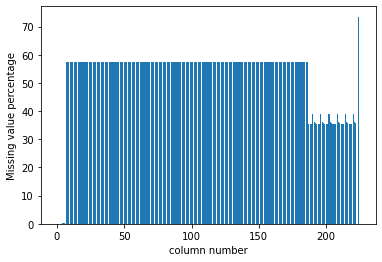

In [25]:
plt.bar(range(len(percent_missing)),percent_missing)
plt.xlabel("column number")
plt.ylabel("Missing value percentage")

ICU
0    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
1    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
dtype: object

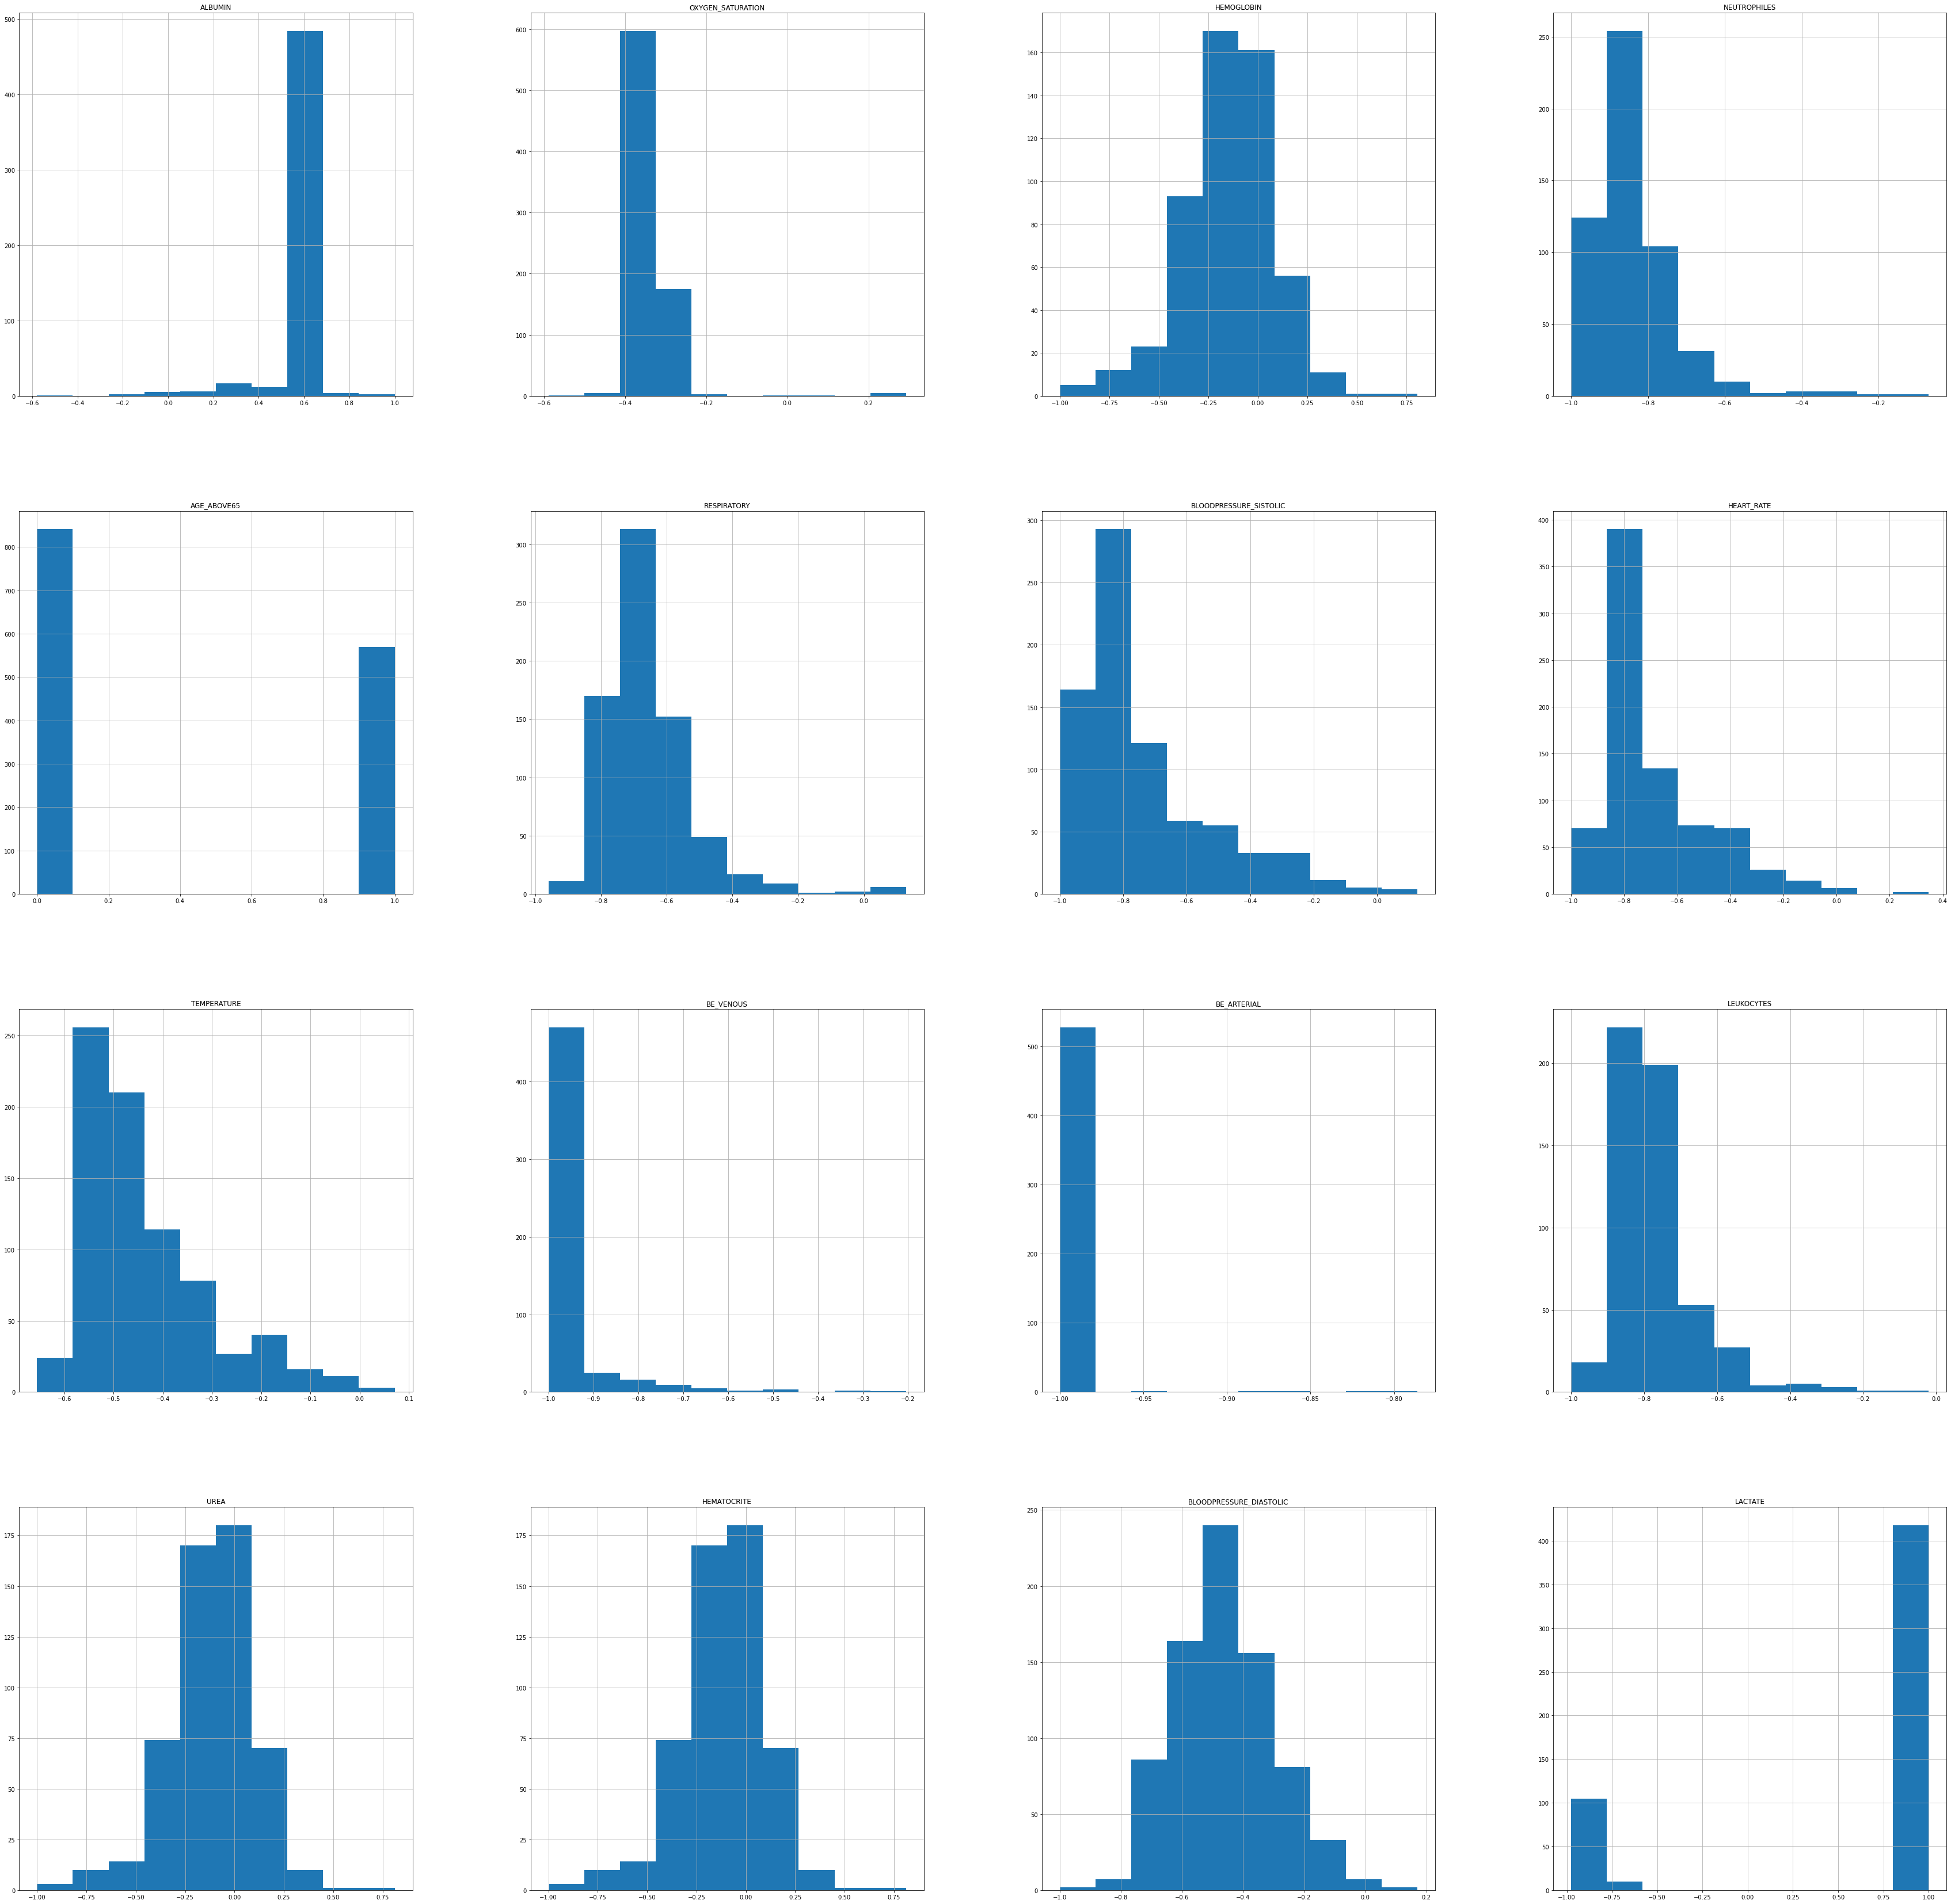

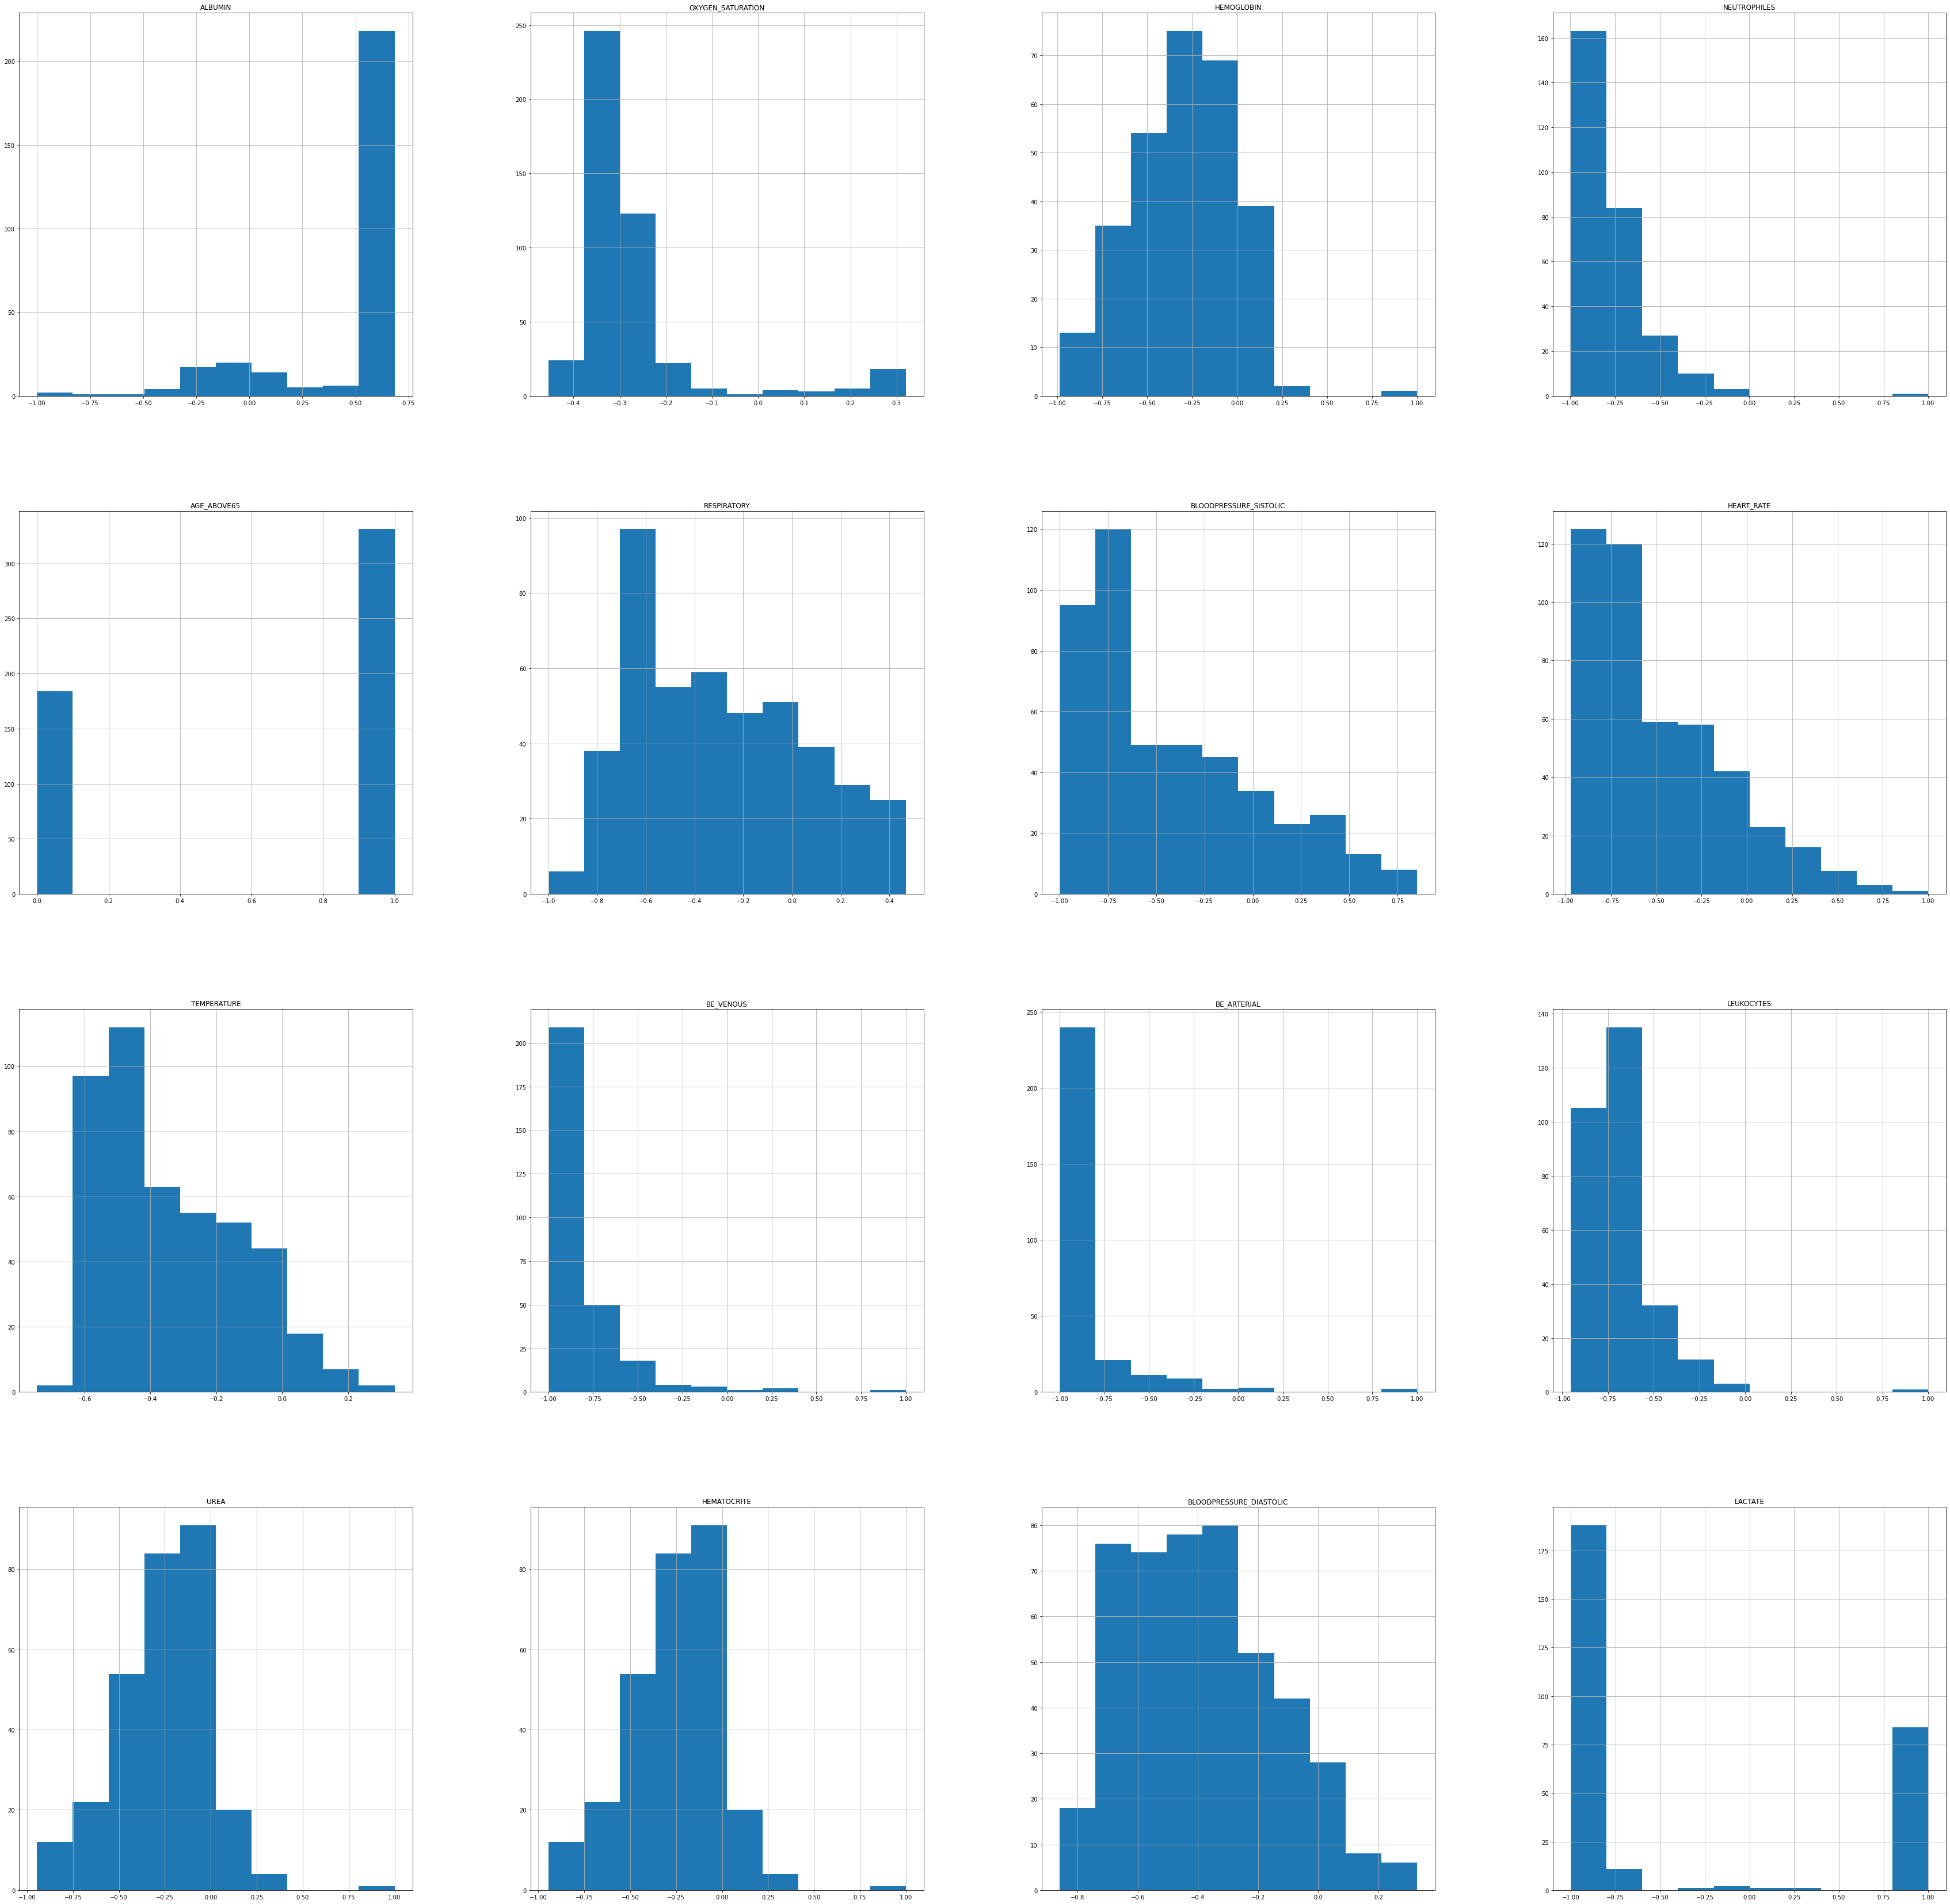

In [26]:
df.groupby('ICU').hist(figsize=(60, 60))

## Data information

The other points about this description are : 
 - The std of "PATIENT_VISIT_IDENTIFIER" is very large
 - Most of the patients are Male. (approximately 63.1 %)
 - Most of the patients don't need to ICU. (approximately 73.2 %)
 - Most of the patients are below 65. (approximately 53.2 %)
 - Most of the patients who have the tag got "Motor Neurone Disease" (approximately 48 %)
 - There are 216 float features, four integer features, and five object features.
 - MOst of features have so many NULL value.(approximately 57 %)
 - Most of the patients who havn't the tag got "Kidney disease"
 - Most of the patients are non-smoker but Smoking affects the lungs, which also affects the corona
 - The number of patients is almost the same from each age range.
 - The need for icu is more at older ages.
 -  The Vital Signs in the dataset include : BLOODPRESSURE DIASTOLIC, BLOODPRESSURE SISTOLIC, HEART RATE, RESPIRATORY RATE, TEMPERATURE, and OXYGEN SATURATION.

#### Data.describe

In [27]:
icu_Data.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,0.605263,0.605263,0.605263,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,0.605263,0.605263,0.605263,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.605263,0.605263,0.605263,0.605263,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature engineering

We have 1925 data for 226 features for 385 patients.

it shows most of data is for same paitient that has been measured in different time period and also number of features are so high for prediction so we should reduce the number of features by detect important ones.

- Remove patients that need ICU at first: WINDOW
- non-numeric features
- Remove some columns
- Remove Features with low Correlation
- Remove features that duplicated value in rows
- Replace missing values
- Scaling and normalize dataset

#### Remove patients that need ICU at first: WINDOW = 0-2 and ICU = 1

In [28]:
dataset = icu_Data.copy()
patient_in_ICU_first = dataset.query('ICU == 1 and WINDOW == "0-2"')['PATIENT_VISIT_IDENTIFIER'].values
dataset = dataset[~dataset['PATIENT_VISIT_IDENTIFIER'].isin(patient_in_ICU_first)]
dataset.shape

(1765, 226)

#### non-numeric features.

- Add columns for each type of diseases in tags column

In [29]:
for disease in diseases:
    dataset[disease] = dataset['tags'].str.contains(disease)
    dataset[disease] = dataset[disease].fillna(False).astype(int)
    
dataset.drop(columns=["tags"], inplace=True)
dataset.tail()[list(diseases)]
dataset.shape

(1765, 231)

- Encoding Age_PERCENTIL column

As we see in plot that we can change Age_PERCENTIL column by this way because whatever age increase the number of patient that need to go ICU increase too.

In [30]:
cleanup_nums = {"AGE_PERCENTIL":
                {"10th": 0.1, "20th": 0.2, "30th": 0.3, "40th": 0.4, "50th": 0.5, "60th": 0.6, "70th": 0.7, "80th": 0.8, "90th": 0.9, "Above 90th": 1}}
dataset = dataset.replace(cleanup_nums)

- Encoding WINDOW column

First we sort the data by visit identifier number and window feature.
Use label encoder and normalize the result between 0 and 1

In [31]:
dataset.sort_values(by=['PATIENT_VISIT_IDENTIFIER', 'WINDOW']).groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)

In [32]:
label_encoder = LabelEncoder()
dataset['WINDOW'] = label_encoder.fit_transform(dataset['WINDOW']) * 0.1 + 0.1
dataset['WINDOW']

0       0.1
1       0.2
2       0.3
3       0.4
4       0.5
10      0.1
11      0.2
12      0.3
13      0.4
14      0.5
15      0.1
16      0.2
17      0.3
18      0.4
19      0.5
20      0.1
21      0.2
22      0.3
23      0.4
24      0.5
25      0.1
26      0.2
27      0.3
28      0.4
29      0.5
30      0.1
31      0.2
32      0.3
33      0.4
34      0.5
35      0.1
36      0.2
37      0.3
38      0.4
39      0.5
40      0.1
41      0.2
42      0.3
43      0.4
44      0.5
45      0.1
46      0.2
47      0.3
48      0.4
49      0.5
50      0.1
51      0.2
52      0.3
53      0.4
54      0.5
55      0.1
56      0.2
57      0.3
58      0.4
59      0.5
60      0.1
61      0.2
62      0.3
63      0.4
64      0.5
65      0.1
66      0.2
67      0.3
68      0.4
69      0.5
70      0.1
71      0.2
72      0.3
73      0.4
74      0.5
75      0.1
76      0.2
77      0.3
78      0.4
79      0.5
80      0.1
81      0.2
82      0.3
83      0.4
84      0.5
90      0.1
91      0.2
92      0.3
93  

#### Remove some columns

We can remove all mean columns that corrletaions between it and median is more than 0.9

Note: For Diff and Rell columns; we remove Diff columns before in features that have same values in rows.

In [33]:
dataset.drop(columns=[
    "HEART_RATE_MEAN",
    "BLOODPRESSURE_SISTOLIC_MEAN",
    "TEMPERATURE_MEAN",
    "BLOODPRESSURE_DIASTOLIC_MEAN",
    "RESPIRATORY_RATE_MEAN",
    "OXYGEN_SATURATION_MEAN"
], inplace=True)
dataset.shape

(1765, 225)

#### Remove Features with low Correlation

Remove the features that have correlation less than 0.1 with target column(ICU).

Note: By this way the columns that have 0 correlation(have same value in rows) will be deleted too.

In [34]:
attributes = corr[(corr > 0.1)]
dataset = icu_Data[attributes.index]
dataset.columns

Index(['ICU', 'RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF_REL', 'LACTATE_MAX', 'LACTATE_MIN',
       'LACTATE_MEAN', 'LACTATE_MEDIAN', 'RESPIRATORY_RATE_MEAN',
       'BLOODPRESSURE_SISTOLIC_DIFF',
       ...
       'PC02_VENOUS_MEAN', 'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN',
       'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'TEMPERATURE_MEDIAN',
       'GGT_MEAN', 'GGT_MAX', 'GGT_MIN', 'GGT_MEDIAN'],
      dtype='object', length=110)

#### Remove features that duplicated value in rows

In [35]:
dataset = dataset.T.drop_duplicates().T
dataset.shape

(1925, 53)

#### Replace missing values

For each person and each column, select a middle of patient's data and replace the NaN values in that column and the data related to that person.

In [36]:
dataset = pd.concat([dataset.iloc[:, 0], dataset[dataset.columns[1:]].fillna(method = 'bfill').fillna(method = 'ffill')], ignore_index = False, axis = 1)
percent_miss = dataset.isnull().sum() * 100 / len(dataset)
list(percent_miss)
dataset.shape

(1925, 53)

#### Scaling and normalize dataset

- For scaling process use "MinMaxScaler" function that working with this formula:
y = (x – min) / (max – min)

In [37]:
data_label = dataset['ICU'].copy()
data = dataset.copy().drop('ICU', axis=1)
trans = MinMaxScaler()
X = pd.DataFrame(data, columns=data.columns)
y = np.array(data_label).reshape(-1, 1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_test=np.ravel(y_test)  
y_train=np.ravel(y_train)  

# Modeling

For tuning hyperparameters of models we use this site
https://ai.plainenglish.io/hyperparameter-tuning

Function to calculate F1_score and use gridsearch to tuning Hyperparameters

In [39]:
def display_scores(model_name, params):
    print("============================", str(model_name), "==========================")
    start_time = time.time()
    model = model_name()
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = 10, n_jobs = -1, verbose = 1, return_train_score=True, scoring = 'f1_weighted')
    grid_search.fit(X_train, y_train);
    best_grid = grid_search.best_estimator_
    best_grid_predictions = best_grid.predict(X_train)
    model_f1_weighted = f1_score(y_train, best_grid_predictions, average='weighted')
    model_f1_micro = f1_score(y_train, best_grid_predictions, average='micro')
    model_f1_macro = f1_score(y_train, best_grid_predictions, average='macro')
    model_f1_binary = f1_score(y_train, best_grid_predictions, average='binary')
    
    model_f1_mean = (model_f1_binary + model_f1_macro + model_f1_micro + model_f1_weighted) / 4
    report = {"score":
                {"F1-weighted": [model_f1_weighted], "F1-micro": [model_f1_micro], "F1-macro": [model_f1_macro], "binary": [model_f1_binary], "Mean": [model_f1_mean]}}
    print("--- %s seconds ---" % (time.time() - start_time))
    report = pd.DataFrame(data = report).T
    print(report)

## Decision Tree Classifier

In [40]:
tree_param = {
    'presort': ['deprecated'],
    'min_weight_fraction_leaf': [0.0],
    'max_features': [2, 15],
    'min_samples_leaf': range(5,50,5),
    'min_samples_split': range(5,50,5),
    'splitter': ['best'],
    'min_impurity_split' : [None],
    'min_weight_fraction_leaf': [0.0],
    'random_state': [None],
    'min_impurity_decrease': [0.0],
    'max_leaf_nodes': [None],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1,10),
    'class_weight': [None]
}

display_scores(DecisionTreeClassifier, tree_param)

============================ <class 'sklearn.tree._classes.DecisionTreeClassifier'> ==========================
Fitting 10 folds for each of 2916 candidates, totalling 29160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 5720 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 9320 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 13720 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 18920 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 24920 tasks      | elapsed:  1.2min


--- 83.07046580314636 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.8427917300854425]  [0.8814968814968815]  [0.8798210998016935]   

                       Mean                binary  
score  [0.8422241266080401]  [0.7647867950481431]  


[Parallel(n_jobs=-1)]: Done 29160 out of 29160 | elapsed:  1.4min finished


## Extra Trees Classifier

Get Hyperparameters of Extra Tree:
https://www.kaggle.com/eikedehling/extra-trees-tuning

In [41]:
extra_trees_param={
        'n_estimators': [5, 50, 150],
        'max_features': [2, 15, 50],
        'min_samples_leaf': [2, 15, 50, 120],
        'min_samples_split': [2, 15, 50, 120],
        'n_jobs': [4]
    }
display_scores(ExtraTreesClassifier, extra_trees_param)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> ==========================
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.2min finished


--- 74.69249200820923 seconds ---
                   F1-macro              F1-micro          F1-weighted  \
score  [0.9793716844686293]  [0.9840609840609841]  [0.984040536533692]   

                       Mean                binary  
score  [0.9792524072260912]  [0.9695364238410595]  


## Random Forest Classifier

In [42]:
random_forest_param = {
    'bootstrap': [False, True],
    'max_depth': [50, 110, 150],
    'max_features': [2, 15, 50],
    'min_samples_leaf': [2, 15, 50, 120],
    'min_samples_split': [2, 15, 50, 120],
    'n_estimators': [5, 50, 150]
}
display_scores(ExtraTreesClassifier, extra_trees_param)

============================ <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> ==========================
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 722 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:   51.5s


--- 74.85803532600403 seconds ---
                  F1-macro              F1-micro           F1-weighted  \
score  [0.978456362812965]  [0.9833679833679834]  [0.9833394688800007]   

                       Mean                binary  
score  [0.9783333940835397]  [0.9681697612732096]  


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.2min finished


## AdaBoost Classifier

In [43]:
AdaBoost_param = {"n_estimators": [1, 2, 10, 30, 50, 80, 120]}
display_scores(AdaBoostClassifier, AdaBoost_param)

============================ <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> ==========================
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.0s finished


--- 5.113236427307129 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.9026380246259764]  [0.9265419265419266]  [0.9255389656223761]   

                       Mean                binary  
score  [0.9022786302964709]  [0.8543956043956045]  


## Logistic Regression

In [44]:
Logistic_params = {
    'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2', 'l1'],
    'n_jobs': [-1],
    'solver': ['saga'],
    'tol': [1e-2],
    'max_iter': [2, 5, 30, 50, 80, 120, 150, 200]
}

display_scores(LogisticRegression, Logistic_params)

============================ <class 'sklearn.linear_model._logistic.LogisticRegression'> ==========================
Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1265 out of 1280 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:    8.6s finished


--- 8.776116371154785 seconds ---
                   F1-macro             F1-micro          F1-weighted  \
score  [0.7641561912189749]  [0.841995841995842]  [0.828474841137134]   

                       Mean                binary  
score  [0.7658228423664895]  [0.6286644951140065]  


C:\Users\Ali\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## SGD Classifier

In [45]:
SGD_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'penalty': ['l2'],
    'n_jobs': [-1]
}

display_scores(SGDClassifier, SGD_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> ==========================
Fitting 10 folds for each of 8 candidates, totalling 80 fits
--- 0.40691184997558594 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.6743302914336179]  [0.8087318087318087]  [0.7736453284878364]   

                       Mean                binary  
score  [0.6804559269307576]  [0.4651162790697675]  


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished


## Passive Aggressive Classifier

I use this site for learnig this model:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html

and also use this site for tuning Hyperparameters:

https://python.hotexamples.com/examples/sklearn.linear_model/PassiveAggressiveClassifier/-/python-passiveaggressiveclassifier-class-examples.html

In [46]:
passive_Ag_param = {'C' : [0.003, 0.01, 0.03, 0.1, 0.3, 1], 'loss': ['hinge', 'squared_hinge'], 'max_iter': [5, 10, 30, 100, 300, 1000]}

display_scores(PassiveAggressiveClassifier, passive_Ag_param)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'> ==========================
Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


--- 2.5890774726867676 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.8128145386766077]  [0.8572418572418572]  [0.8561043156569719]   

                       Mean                binary  
score  [0.8119455832992646]  [0.7216216216216217]  


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    2.4s finished


## K Neighbors Classifier

In [47]:
k_neighbors_params = {'weights': ['uniform', 'distance'],
                      'n_neighbors': [1, 2, 5, 30, 50, 80, 120]}

display_scores(KNeighborsClassifier, k_neighbors_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.neighbors._classification.KNeighborsClassifier'> ==========================
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    5.9s finished


--- 6.219372510910034 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.9790448746158795]  [0.9840609840609841]  [0.9839117796723904]   

                       Mean                binary  
score  [0.9789525099943692]  [0.9687924016282226]  


## Naive Bayes

In [48]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

### 1  Gaussian Naive Bayes

In [49]:
Gaus_params = {'var_smoothing': [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.00000001, 0.000000001, 0.00000001]}

display_scores(GaussianNB, Gaus_params)

============================ <class 'sklearn.naive_bayes.GaussianNB'> ==========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


--- 0.41788244247436523 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.7170868421804687]  [0.7955647955647956]  [0.7878202606913423]   

                       Mean               binary  
score  [0.7171384724129584]  [0.568081991215227]  


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


### 2 Bernoulli Naive Bayes

In [50]:
Ber_param = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
             }

display_scores(BernoulliNB, Ber_param)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.naive_bayes.BernoulliNB'> ==========================
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


--- 0.23337340354919434 seconds ---
                   F1-macro              F1-micro          F1-weighted  \
score  [0.7265761421981287]  [0.8135828135828136]  [0.799794287036592]   

                       Mean                binary  
score  [0.7280725714357033]  [0.5723370429252782]  


## Perceptron

Use thise linke for more:

https://github.com/manurFR/machine-learning-fun/blob/master/pima/03_perceptron.py

In [51]:
Percep_parameter = {'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],'n_iter_no_change': [5, 10, 15, 20, 50]}

display_scores(Perceptron, Percep_parameter)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.linear_model._perceptron.Perceptron'> ==========================
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


--- 1.7792446613311768 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.7777064376987465]  [0.8101178101178101]  [0.8180000676571106]   

                       Mean                binary  
score  [0.7746623568953226]  [0.6928251121076233]  


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.6s finished


## Gradient Boosting Classifier

In [52]:
np.linspace(0.1, 5, 15)

array([0.1 , 0.45, 0.8 , 1.15, 1.5 , 1.85, 2.2 , 2.55, 2.9 , 3.25, 3.6 ,
       3.95, 4.3 , 4.65, 5.  ])

Use this site for learning model:

https://stackoverflow.com/questions/32664717/got-continuous-is-not-supported-error-in-randomforestregressor

In [53]:
GradientBoost_parameter = {"loss":["deviance"],
 "learning_rate": [0.01, 0.1, 1],
    "min_samples_split": [0.1, 0.8, 2, 5],
    "min_samples_leaf": [0.1, 0.8, 2, 5],
    "max_depth":[1,10],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.1, 1.0],
    "n_estimators":[10, 100]
    }
display_scores(GradientBoostingClassifier, GradientBoost_parameter)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.ensemble._gb.GradientBoostingClassifier'> ==========================
Fitting 10 folds for each of 1536 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1964 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 3234 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 4920 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7057 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8854 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 10222 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 11674 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 14169 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 15360 out of 15360 | elapsed: 22.0min finished


--- 1320.5857129096985 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.9794068574314694]  [0.9840609840609841]  [0.9840541996198332]   

                       Mean                binary  
score  [0.9792847374907533]  [0.9696169088507265]  


## Hist Gradient Boosting Classifier

In [54]:
HistGrad_params = {
 'max_iter': [1000,1500],
 'learning_rate': [0.1, 1],
 'max_depth': [25, 75],
 'l2_regularization': [0.1,1.5],
 'scoring': ['loss'],
 'early_stopping': ['auto'],
 }

display_scores(HistGradientBoostingClassifier, HistGrad_params)

============================ <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'> ==========================
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  9.0min finished


--- 568.2067341804504 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.9794068574314694]  [0.9840609840609841]  [0.9840541996198332]   

                       Mean                binary  
score  [0.9792847374907533]  [0.9696169088507265]  


## SVC

In [55]:
SVC_params = {'kernel': ['rbf', 'linear'], 
              'gamma': [1e-3, 1e-4],
              'C': [1, 10, 100, 1000]}
display_scores(SVC, SVC_params)

============================ <class 'sklearn.svm._classes.SVC'> ==========================
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s


--- 57.562652587890625 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.8110684601124383]  [0.8648648648648649]  [0.8589263007038825]   

                       Mean                binary  
score  [0.8112780564945906]  [0.7102526002971767]  


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   57.3s finished


## MLP Classifier

In [56]:
MLP_parameter = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
display_scores(MLPClassifier, MLP_parameter)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


============================ <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> ==========================
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.4min finished


--- 85.415354013443 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.8206618287720259]  [0.8704088704088704]  [0.8654996228789185]   

                       Mean               binary  
score  [0.8206945570888923]  [0.726207906295754]  


C:\Users\Ali\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Linear Discriminant Analysis

A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.

The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.

The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method

In [57]:
Discrim_parameter = {"solver" : ["svd"],
                     "tol" : [0.0001,0.0002,0.0003]}

display_scores(LinearDiscriminantAnalysis, Discrim_parameter)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


============================ <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> ==========================
Fitting 10 folds for each of 3 candidates, totalling 30 fits
--- 0.20645427703857422 seconds ---
                  F1-macro              F1-micro           F1-weighted  \
score  [0.807192941345514]  [0.8620928620928622]  [0.8560324812311418]   

                       Mean                binary  
score  [0.8074068371406337]  [0.7043090638930164]  


# Choose model

As we see the F1_weighted number of ((Hist Gradient Boosting Classifier)) , ((Gradient Boosting Classifier)) ,

((K Neighbors Classifier)) , ((Extra Trees Classifier)) and ((Random Forest Classifier)) are more than others and

almost equal(0.984).

so we calculate and plot the F1 by ((cross_val_score)) and without any hyperparameters again to decide for choosing better model by this way because in my 

function we do it twice and it may cause a problem.

C:\Users\Ali\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


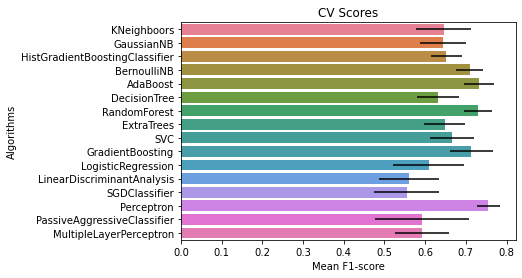

In [58]:
random_s = 2

models = []
cv_results = []
cv_means = []
cv_std = [] 

models.append(KNeighborsClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_s),random_state=random_s,learning_rate=0.1))
models.append(DecisionTreeClassifier(random_state=random_s))
models.append(RandomForestClassifier(random_state=random_s))
models.append(ExtraTreesClassifier(random_state=random_s))
models.append(SVC(random_state=random_s))
models.append(GradientBoostingClassifier(random_state=random_s))
models.append(LogisticRegression(random_state = random_s))
models.append(LinearDiscriminantAnalysis())
models.append(MLPClassifier(random_state=random_s))
models.append(SGDClassifier(random_state=random_s))
models.append(BernoulliNB())
models.append(GaussianNB())
models.append(HistGradientBoostingClassifier(random_state=random_s))
models.append(Perceptron(random_state=random_s))
models.append(PassiveAggressiveClassifier(random_state=random_s))

for model in models :
    cv_results.append(cross_val_score(model, X_train, y_train, 
                                      scoring = "f1", cv = 10, n_jobs=4))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_frame = pd.DataFrame(
    {
        "CrossValMeans":cv_means,
        "CrossValErrors": cv_std,
        "Algorithms":[
                     "KNeighboors",
                     "GaussianNB",
                     "HistGradientBoostingClassifier",
                     "BernoulliNB",
                     "AdaBoost", 
                     "DecisionTree",   
                     "RandomForest",
                     "ExtraTrees",
                     "SVC",
                     "GradientBoosting",                      
                     "LogisticRegression",
                     "LinearDiscriminantAnalysis",
                     "SGDClassifier",
                     "Perceptron",
                     "PassiveAggressiveClassifier",
                     "MultipleLayerPerceptron"]
    })

cv_plot = sns.barplot("CrossValMeans","Algorithms", data = cv_frame,
                palette="husl", orient = "h", **{'xerr':cv_std})

cv_plot.set_xlabel("Mean F1-score")
cv_plot = cv_plot.set_title("CV Scores")

# Final Model

At lase I choose ((Random Forest)) for modeling Data,because the mean of it's F1 is more than other in both of ways to calculate

In [59]:
random_forest_param = {
    'bootstrap': [False, True],
    'max_depth': [50, 110, 150],
    'max_features': [2, 15, 50],
    'min_samples_leaf': [2, 15, 50, 120],
    'min_samples_split': [2, 15, 50, 120],
    'n_estimators': [5, 50, 150]
}
start_time = time.time()
model = RandomForestClassifier(random_state = 2)
grid_search = GridSearchCV(estimator = model, param_grid = random_forest_param, cv = 10, n_jobs = -1, verbose = 1, return_train_score=True, scoring = 'f1_weighted')
grid_search.fit(X_test, y_test);
best_grid = grid_search.best_estimator_
best_grid_predictions = best_grid.predict(X_test)
model_f1_weighted = f1_score(y_test, best_grid_predictions, average='weighted')
model_f1_micro = f1_score(y_test, best_grid_predictions, average='micro')
model_f1_macro = f1_score(y_test, best_grid_predictions, average='macro')
model_f1_binary = f1_score(y_test, best_grid_predictions, average='binary')
    
model_f1_mean = (model_f1_binary + model_f1_macro + model_f1_micro + model_f1_weighted) / 4
report = {"score":
                {"F1-weighted": [model_f1_weighted], "F1-micro": [model_f1_micro], "F1-macro": [model_f1_macro], "binary": [model_f1_binary], "Mean": [model_f1_mean]}}
print("--- %s seconds ---" % (time.time() - start_time))
report = pd.DataFrame(data = report).T
print(report)

Fitting 10 folds for each of 864 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2714 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3600 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4450 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 6450 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7600 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed:  5.8min finished


--- 348.9636697769165 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.9817852997543661]  [0.9854771784232366]  [0.9853580855629503]   

                       Mean                binary  
score  [0.9815513673502325]  [0.9735849056603774]  


# Ensemble Learning

Finally I test the ((voting classifier)) for ensemble all the models together but it's just extra procces.

In [60]:
model = VotingClassifier(estimators=[('Logistic', LogisticRegression(random_state = 2)),
                                    ('Random_Forest', RandomForestClassifier(random_state=2)),
                                    ('Gaussian_NB', GaussianNB()),
                                    ('Bernoulli_NB', BernoulliNB()),
                                    ('perceptron', Perceptron(random_state=2)),
                                    ('SGD', SGDClassifier(random_state=2)),
                                    ('grid_search', grid_search),
                                    ('Gradient_Boosting', GradientBoostingClassifier(random_state=2)),
                                    ('Hist_Gradient_Boosting', HistGradientBoostingClassifier(random_state=2)),
                                    ('tree', DecisionTreeClassifier(random_state=2)),
                                    ('AdaBoost', AdaBoostClassifier(DecisionTreeClassifier(random_state=2),random_state=2,learning_rate=0.1)),
                                    ('Passive_Aggressive', PassiveAggressiveClassifier(random_state=2)),
                                    ('K_Neighbors', KNeighborsClassifier()),
                                    ('SVC', SVC(random_state=2)),
                                    ('Extra_Trees', ExtraTreesClassifier(random_state=2)),
                                    ('Linear_Discriminant_Analysis', LinearDiscriminantAnalysis()),
                                    ('MLP_Classifier', MLPClassifier(random_state=2))], voting = 'hard')
start_time = time.time()
model.fit(X_train, y_train)
model_predictions = model.predict(X_train)
model_f1_weighted = f1_score(y_train, model_predictions, average='weighted')
model_f1_micro = f1_score(y_train, model_predictions, average='micro')
model_f1_macro = f1_score(y_train, model_predictions, average='macro')
model_f1_binary = f1_score(y_train, model_predictions, average='binary')
    
model_f1_mean = (model_f1_binary + model_f1_macro + model_f1_micro + model_f1_weighted) / 4
report = {"score":
                {"F1-weighted": [model_f1_weighted], "F1-micro": [model_f1_micro], "F1-macro": [model_f1_macro], "binary": [model_f1_binary], "Mean": [model_f1_mean]}}
print("--- %s seconds ---" % (time.time() - start_time))
report = pd.DataFrame(data = report).T
print(report)

C:\Users\Ali\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 10 folds for each of 864 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1506 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2056 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2706 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4306 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 6306 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 7456 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 13.8min finished
C:\Users\Ali\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: Con

--- 837.0087554454803 seconds ---
                   F1-macro              F1-micro           F1-weighted  \
score  [0.8894882475750947]  [0.9203049203049203]  [0.9171908995697541]   

                      Mean                binary  
score  [0.889528689402824]  [0.8311306901615272]  


# resources

some other resources that i used

- https://github.com/NanditaA/ML-Supervised-Classification/blob/master/Breast%20Cancer%20Classification.ipynb

- https://www.codementor.io/@innat_2k14/kaggl-titanic-a-machine-learning-from-disaster-modelling-part-2-10gfjtm0p3

- https://scikit-learn.org/